# Import and loading entire dataset

In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import os

# Load the full training data
# Ensure the path '../data/train.csv' is correct for your environment
full_df = pd.read_csv('../data/train.csv')

print(f"Full Dataset Shape: {full_df.shape}")

Full Dataset Shape: (59611, 24)


# Randomly selecting 20% of data also saving it for future reference

In [75]:
# Randomly sample 20% of the data
# random_state=42 ensures reproducibility
mini_df = full_df.sample(frac=0.2)

print(f"Mini Training Data Shape (20% of Original): {mini_df.shape}")

# Save the mini dataset to a CSV file for reference
output_filename = 'mini_train_data.csv'
mini_df.to_csv(output_filename, index=False)
print(f"✅ Saved mini training data to: {os.path.abspath(output_filename)}")

print("We are now working exclusively with this subset.")

Mini Training Data Shape (20% of Original): (11922, 24)
✅ Saved mini training data to: /Users/harshsinha/Desktop/iiitbSemester/Sem5/MachineLearning/final2ndHalf/twentyPercentData/mini_train_data.csv
We are now working exclusively with this subset.


# Functions for pre processing

In [76]:
def clean_data(df):
    # 1. Drop Duplicates
    df = df.drop_duplicates()
    
    # 2. Anomaly Removal
    # Keep only founders 18 or older
    df = df[df['founder_age'] >= 18]
    
    # Keep only valid tenures (started at age 16+)
    df = df[(df['founder_age'] - df['years_with_startup']) >= 16]
    
    # 3. Missing Value Imputation
    # Numerical: Median (robust to outliers)
    num_cols = ['monthly_revenue_generated', 'years_since_founding', 'num_dependents']
    for col in num_cols:
        df[col] = df[col].fillna(df[col].median())
        
    # Categorical: Treat "Missing" as "Unknown" for psychological surveys
    df['work_life_balance_rating'] = df['work_life_balance_rating'].fillna('Unknown')
    df['venture_satisfaction'] = df['venture_satisfaction'].fillna('Unknown')
    
    # For other structural columns, use Mode
    df['team_size_category'] = df['team_size_category'].fillna(df['team_size_category'].mode()[0])
    
    # 4. Feature Engineering (Simplification)
    df['start_age'] = df['founder_age'] - df['years_with_startup']
    
    # 5. Encoding Target
    target_map = {'Stayed': 0, 'Left': 1}
    df['target'] = df['retention_status'].map(target_map)
    
    # Drop unused columns
    cols_to_drop = ['founder_id', 'retention_status']
    df = df.drop(columns=cols_to_drop)
    
    return df

def encode_and_split_mini(df):
    # --- 1. ORDINAL ENCODING ---
    rating_map = {'Unknown': 0, 'Low': 1, 'Poor': 1, 'Below Average': 2, 
                  'Fair': 3, 'Medium': 3, 'Average': 3, 
                  'Good': 4, 'High': 4, 'Very High': 5, 'Excellent': 5}
    
    ord_cols = ['work_life_balance_rating', 'venture_satisfaction', 
                'startup_performance_rating', 'startup_reputation', 'founder_visibility']
    
    for col in ord_cols:
        df[col] = df[col].map(rating_map).fillna(0)

    # Map Binary Columns
    binary_map = {'No': 0, 'Yes': 1}
    bin_cols = ['working_overtime', 'remote_operations', 'innovation_support', 'leadership_scope']
    for col in bin_cols:
        df[col] = df[col].map(binary_map)

    # Map Startup Stage
    stage_map = {'Entry': 1, 'Mid': 2, 'Senior': 3, 'Growth': 3, 'Established': 4}
    df['startup_stage'] = df['startup_stage'].map(stage_map).fillna(1)

    # --- 2. ONE-HOT ENCODING ---
    df = pd.get_dummies(df, columns=['founder_gender', 'founder_role', 
                                     'education_background', 'personal_status', 
                                     'team_size_category'], drop_first=True)

    # --- 3. SEPARATE X and y ---
    X = df.drop('target', axis=1)
    y = df['target']
    
    # --- 4. INTERNAL SPLIT (80/20 of the Mini Data) ---
    # This splits the Mini Data into Training (80%) and Evaluation (20%) sets
    X_train_mini, X_test_mini, y_train_mini, y_test_mini = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # --- 5. SCALING ---
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_mini)
    # Important: Transform test set using the scaler fitted on training set
    X_test_scaled = scaler.transform(X_test_mini)
    
    # Convert back to DataFrame for readability
    X_train_final = pd.DataFrame(X_train_scaled, columns=X.columns)
    X_test_final = pd.DataFrame(X_test_scaled, columns=X.columns)
    
    return X_train_final, X_test_final, y_train_mini, y_test_mini

# Preprocessing the mini dataset

In [77]:
# 1. Clean the Mini Data
print("Cleaning Mini Data...")
mini_df_clean = clean_data(mini_df)
print(f"Cleaned Mini Data Shape: {mini_df_clean.shape}")

# 2. Encode and Split (80/20 split inside here)
print("Encoding and Splitting Mini Data...")
X_train, X_test, y_train, y_test = encode_and_split_mini(mini_df_clean)

print(f"\n--- Split Results on Mini Data ---")
print(f"Training Set (80%): {X_train.shape}")
print(f"Testing Set (20%):  {X_test.shape}")

Cleaning Mini Data...
Cleaned Mini Data Shape: (8122, 24)
Encoding and Splitting Mini Data...

--- Split Results on Mini Data ---
Training Set (80%): (6497, 31)
Testing Set (20%):  (1625, 31)


# SVM

In [78]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score

print("Training SVM on Mini Training Data with EXTENDED Hyperparameter Tuning...")

# 1. Define the Expanded Parameter Grid
param_distributions = {
    # Kernel: The math used to draw the line
    "kernel": ["rbf", "poly", "sigmoid"], 
    
    # C: Penalty parameter (Trade-off between smooth decision boundary and classifying training points correctly)
    "C": uniform(0.1, 10),       
    
    # Gamma: Kernel coefficient (Low = far, High = close)
    "gamma": ["scale", "auto"],
    
    # Degree: Only for 'poly' kernel
    "degree": [2, 3, 4],
    
    # Class Weight: 'balanced' automatically adjusts weights inversely proportional to class frequencies
    "class_weight": ['balanced', None],
    
    # Shrinking: Whether to use the shrinking heuristic (can speed up training)
    "shrinking": [True, False],
    
    # Decision Function Shape: 'ovo' (one-vs-one) or 'ovr' (one-vs-rest)
    # Note: For binary classification, they behave similarly, but good to test.
    "decision_function_shape": ['ovo', 'ovr']
}

# 2. Initialize the Base Model
# probability=True is not strictly needed for F1/Accuracy but good if you need predict_proba later
svm_base = SVC(random_state=42)

# 3. Setup Randomized Search
random_search_svm = RandomizedSearchCV(
    estimator=svm_base,
    param_distributions=param_distributions,
    n_iter=30,     # INCREASED: Tries 30 random combinations now
    cv=3,          # 3-Fold Cross Validation
    verbose=1,     
    random_state=42,
    n_jobs=-1,
    scoring='f1_macro' # Optimize for balanced performance
)

# 4. Train
print("Searching for best SVM parameters (this may take 2-3 mins)...")
random_search_svm.fit(X_train, y_train)

# 5. Get the Best Model
best_svm = random_search_svm.best_estimator_

print(f"\n✅ Best SVM Parameters: {random_search_svm.best_params_}")
print(f"Best Validation F1 Macro Score: {random_search_svm.best_score_:.2%}")

# 6. Predict
y_pred_svm = best_svm.predict(X_test)

# 7. Final Report
svm_acc = accuracy_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm, average='macro')

print(f"\nSVM Accuracy on Mini Data Test Split: {svm_acc:.2%}")
print(f"SVM F1 Macro Score: {svm_f1:.2%}")
print("\nClassification Report (SVM Tuned):")
print(classification_report(y_test, y_pred_svm, target_names=['Stayed', 'Left']))

Training SVM on Mini Training Data with EXTENDED Hyperparameter Tuning...
Searching for best SVM parameters (this may take 2-3 mins)...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

✅ Best SVM Parameters: {'C': np.float64(0.17066305219717406), 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'degree': 4, 'gamma': 'scale', 'kernel': 'sigmoid', 'shrinking': False}
Best Validation F1 Macro Score: 73.37%

SVM Accuracy on Mini Data Test Split: 73.17%
SVM F1 Macro Score: 73.15%

Classification Report (SVM Tuned):
              precision    recall  f1-score   support

      Stayed       0.75      0.72      0.74       851
        Left       0.71      0.74      0.72       774

    accuracy                           0.73      1625
   macro avg       0.73      0.73      0.73      1625
weighted avg       0.73      0.73      0.73      1625



# NN

In [79]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, f1_score
from scipy.stats import uniform, loguniform

print("Training Neural Network on Mini Training Data with RESTRICTED Hyperparameter Tuning...")

# 1. Define the "Tone Down" Parameter Grid
param_distributions = {
    # Architecture: drastically reduced capacity
    # We only allow single layers or very small double layers
    'hidden_layer_sizes': [
        (10,), (30,), (50,),        # Single layer with few neurons
        (10, 10), (30, 30)          # Shallow double layer
    ],
    
    # Activation Functions: Removed 'logistic' to keep it standard
    'activation': ['relu', 'tanh'],
    
    # Solvers: Stick to 'adam' (standard) to avoid the specific optimizations of SGD
    'solver': ['adam'],
    
    # Regularization: Standard range
    'alpha': loguniform(1e-4, 1e-2), 
    
    # Learning Rate: Standard range
    'learning_rate_init': loguniform(1e-4, 1e-2)
}

# 2. Initialize the Base Model
# max_iter=500 is enough for small networks
mlp_base = MLPClassifier(max_iter=500, random_state=42)

# 3. Setup Randomized Search
random_search_mlp = RandomizedSearchCV(
    estimator=mlp_base,
    param_distributions=param_distributions,
    n_iter=20,     # Reduced iterations since the grid is smaller
    cv=3,          
    verbose=1,     
    random_state=42,
    n_jobs=-1,
    scoring='f1_macro' 
)

# 4. Train
print("Searching for parameters...")
random_search_mlp.fit(X_train, y_train)

# 5. Get the Best Model
best_mlp = random_search_mlp.best_estimator_

print(f"\n✅ Best MLP Parameters: {random_search_mlp.best_params_}")
print(f"Best Validation F1 Macro Score: {random_search_mlp.best_score_:.2%}")

# 6. Predict
y_pred_mlp = best_mlp.predict(X_test)

# 7. Final Report
mlp_acc = accuracy_score(y_test, y_pred_mlp)
mlp_f1 = f1_score(y_test, y_pred_mlp, average='macro')

print(f"\nNeural Network Accuracy on Mini Data Test Split: {mlp_acc:.2%}")
print(f"Neural Network F1 Macro Score: {mlp_f1:.2%}")
print("\nClassification Report (MLP Tuned):")
print(classification_report(y_test, y_pred_mlp, target_names=['Stayed', 'Left']))

Training Neural Network on Mini Training Data with RESTRICTED Hyperparameter Tuning...
Searching for parameters...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/anaconda3/envs/MlLab/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MlLab/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MlLab/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MlLab/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MlLa


✅ Best MLP Parameters: {'activation': 'relu', 'alpha': np.float64(0.0011208547084229376), 'hidden_layer_sizes': (30,), 'learning_rate_init': np.float64(0.00012397420340784152), 'solver': 'adam'}
Best Validation F1 Macro Score: 73.17%

Neural Network Accuracy on Mini Data Test Split: 72.18%
Neural Network F1 Macro Score: 72.09%

Classification Report (MLP Tuned):
              precision    recall  f1-score   support

      Stayed       0.73      0.75      0.74       851
        Left       0.71      0.70      0.70       774

    accuracy                           0.72      1625
   macro avg       0.72      0.72      0.72      1625
weighted avg       0.72      0.72      0.72      1625



# Model Comparison

MODEL COMPARISON SUMMARY
         Model  Accuracy  F1 Macro Score
           SVM  0.731692        0.731521
Neural Network  0.721846        0.720851

🏆 BEST MODEL: SVM
   Accuracy: 73.17%
   F1 Macro Score: 73.15%


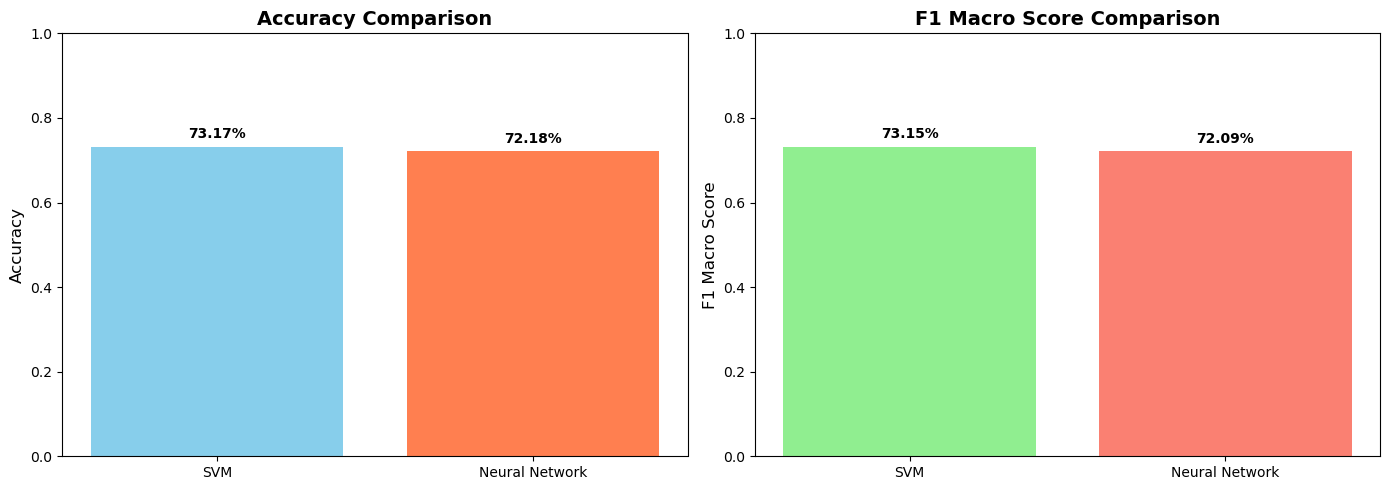


📊 PERFORMANCE DIFFERENCE:
   Accuracy Difference: 0.98%
   F1 Score Difference: 1.07%


In [80]:
import matplotlib.pyplot as plt

# Create comparison dictionary
comparison_data = {
    'Model': ['SVM', 'Neural Network'],
    'Accuracy': [svm_acc, mlp_acc],
    'F1 Macro Score': [svm_f1, mlp_f1]
}

comparison_df = pd.DataFrame(comparison_data)

print("="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)

# Determine best model
if svm_f1 > mlp_f1:
    best_model = "SVM"
    best_f1 = svm_f1
    best_acc = svm_acc
else:
    best_model = "Neural Network"
    best_f1 = mlp_f1
    best_acc = mlp_acc

print(f"\n🏆 BEST MODEL: {best_model}")
print(f"   Accuracy: {best_acc:.2%}")
print(f"   F1 Macro Score: {best_f1:.2%}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy Comparison
axes[0].bar(comparison_df['Model'], comparison_df['Accuracy'], color=['skyblue', 'coral'])
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
for i, v in enumerate(comparison_df['Accuracy']):
    axes[0].text(i, v + 0.02, f'{v:.2%}', ha='center', fontweight='bold')

# Plot 2: F1 Macro Score Comparison
axes[1].bar(comparison_df['Model'], comparison_df['F1 Macro Score'], color=['lightgreen', 'salmon'])
axes[1].set_ylabel('F1 Macro Score', fontsize=12)
axes[1].set_title('F1 Macro Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1])
for i, v in enumerate(comparison_df['F1 Macro Score']):
    axes[1].text(i, v + 0.02, f'{v:.2%}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Performance difference
acc_diff = abs(svm_acc - mlp_acc)
f1_diff = abs(svm_f1 - mlp_f1)

print(f"\n📊 PERFORMANCE DIFFERENCE:")
print(f"   Accuracy Difference: {acc_diff:.2%}")
print(f"   F1 Score Difference: {f1_diff:.2%}")